Working on device: cpu
tiny_nerf_data.npz already exists.
Images shape: torch.Size([100, 100, 100, 3])
Poses shape: torch.Size([100, 4, 4])
Focal length: 138.88887889922103
Resolution: 100x100


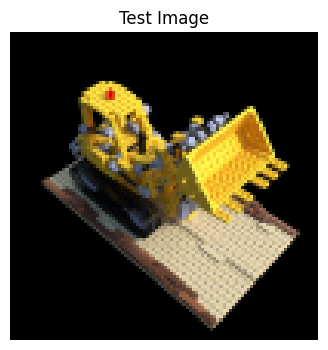

In [6]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import requests

# У меня macOS, поэтому попытка на CPU
device = torch.device('cpu')
print(f"Working on device: {device}")

# Загрузка данных. Nerfstudio базируется на библиотеке tiny-cuda-nn, которая требует CUDA.
# Поэтому безвыходно беру Tiny NeRF. Data - Lego
data_url = "http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz"
filename = "tiny_nerf_data.npz"

if not os.path.exists(filename):
    print(f"Downloading {filename}...")
    response = requests.get(data_url)
    with open(filename, 'wb') as f:
        f.write(response.content)
    print("Download complete.")
else:
    print(f"{filename} already exists.")

# Распаковка данных
data = np.load(filename)
images = data['images']
poses = data['poses']
focal = data['focal']

# Переводим в тензоры PyTorch
H, W = images.shape[1:3]
testimg, testpose = images[101], poses[101]
images = torch.from_numpy(images[:100, ..., :3]).to(device) 
poses = torch.from_numpy(poses[:100]).to(device)
focal = torch.from_numpy(focal).to(device)

print(f"Images shape: {images.shape}") # [N, H, W, 3]
print(f"Poses shape: {poses.shape}")   # [N, 4, 4]
print(f"Focal length: {focal.item()}")
print(f"Resolution: {H}x{W}")

# Визуализация одного кадра 
plt.figure(figsize=(4,4))
plt.imshow(testimg)
plt.title("Test Image")
plt.axis('off')
plt.show()

In [7]:
def get_rays(H, W, focal, c2w):
    # Генерирует лучи для всех пикселей изображения
    # Сетка координат пикселей (i, j)
    i, j = torch.meshgrid(torch.arange(W, dtype=torch.float32), 
                          torch.arange(H, dtype=torch.float32), indexing='xy')
    
    # Перевод пикселей в координаты камеры (нормализованные)
    dirs = torch.stack([(i - W * 0.5) / focal, 
                        -(j - H * 0.5) / focal, 
                        -torch.ones_like(i)], -1).to(device) # [H, W, 3]

    # Поворачиваем направления векторов из системы камеры в мировую систему
    # c2w[:3, :3] матрица поворота
    rays_d = torch.sum(dirs[..., None, :] * c2w[:3, :3], -1) 
    
    # c2w[:3, 3]свектор смещения
    rays_o = c2w[:3, -1].expand(rays_d.shape)
    
    return rays_o, rays_d

def posenc(x, L_embed=6):
    # Positional Encoding
    rets = [x]
    for i in range(L_embed):
        for fn in [torch.sin, torch.cos]:
            rets.append(fn(2.0**i * x))
    return torch.cat(rets, -1)

# Тестируем get_rays на первом кадре
test_c2w = poses[0]
rays_o, rays_d = get_rays(H, W, focal, test_c2w)

print("Rays Origin shape:", rays_o.shape) # Должно быть [100, 100, 3]
print("Rays Direction shape:", rays_d.shape)
print("Пример направления луча (центр):", rays_d[H//2, W//2])

# Тестируем posenc
sample_point = torch.tensor([[0.1, 0.2, 0.3]]).to(device)
encoded = posenc(sample_point, L_embed=6)
print("Исходная размерность:", sample_point.shape[-1])
print("Размерность после PosEnc (3 + 3*2*6):", encoded.shape[-1])

Rays Origin shape: torch.Size([100, 100, 3])
Rays Direction shape: torch.Size([100, 100, 3])
Пример направления луча (центр): tensor([ 0.0133, -0.9539, -0.2997])
Исходная размерность: 3
Размерность после PosEnc (3 + 3*2*6): 39


In [8]:
import torch.nn as nn
import torch.nn.functional as F

# Архитектура нейросети
class NeRFModel(nn.Module):
    def __init__(self, D=4, W=256, input_ch=39, output_ch=4):
        super(NeRFModel, self).__init__()
        layers = [nn.Linear(input_ch, W), nn.ReLU()]
        for i in range(D-1):
            layers.append(nn.Linear(W, W))
            layers.append(nn.ReLU())
        
        # Финальный слой без активации
        layers.append(nn.Linear(W, output_ch))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

# Функция сэмплирования точек на луче (Stratified Sampling)
def sample_points(rays_o, rays_d, near, far, N_samples):

    # Линейная интерполяция глубин от near до far
    z_vals = torch.linspace(near, far, N_samples).to(device)
    
    # Расширяем размерность под количество лучей
    z_vals = z_vals.expand(list(rays_o.shape[:-1]) + [N_samples])
    
    # Cлучайный сдвиг 
    mids = 0.5 * (z_vals[..., 1:] + z_vals[..., :-1])
    upper = torch.cat([mids, z_vals[..., -1:]], -1)
    lower = torch.cat([z_vals[..., :1], mids], -1)
    
    t_rand = torch.rand(z_vals.shape).to(device)
    z_vals = lower + (upper - lower) * t_rand
    
    # Вычисляем 3D координаты точек: o + t * d
    pts = rays_o[..., None, :] + rays_d[..., None, :] * z_vals[..., :, None]
    
    return pts, z_vals

# Объемный рендеринг 
def raw2outputs(raw, z_vals, rays_d):

    # Функция активации для плотности: ReLU 
    sigma = F.relu(raw[..., 3])
    # Функция активации для цвета: Sigmoid 
    rgb = torch.sigmoid(raw[..., :3])
    
    # Вычисляем расстояния между соседними точками 
    dists = z_vals[..., 1:] - z_vals[..., :-1]
    
    dist_far = torch.tensor([1e10], device=device).expand(dists[..., :1].shape)
    dists = torch.cat([dists, dist_far], -1)
    
    # Проецируем расстояние на направление луча (коррекция масштаба)
    dists = dists * torch.norm(rays_d[..., None, :], dim=-1)
    
    # Alpha compositing: вероятность того, что луч поглотится на этом отрезке
    alpha = 1.0 - torch.exp(-sigma * dists)
    
    # Transmittance: вероятность того, что луч дошел до точки i
    weights = alpha * torch.cumprod(torch.cat([torch.ones((alpha.shape[0], 1), device=device), 1.-alpha + 1e-10], -1), -1)[:, :-1]
    
    # Итоговый цвет пикселя: взвешенная сумма цветов точек
    rgb_map = torch.sum(weights[..., None] * rgb, -2)
    
    # Карта глубины
    depth_map = torch.sum(weights * z_vals, -1)
    
    return rgb_map, depth_map, weights

print("Модель и рендеринг определены")

Модель и рендеринг определены


Model re-initialized
Restarting training...
[Iter 0000] Loss: 0.09311 | PSNR: 10.31 dB | ETA: 522s
[Iter 0200] Loss: 0.02335 | PSNR: 16.32 dB | ETA: 302s
[Iter 0400] Loss: 0.00958 | PSNR: 20.18 dB | ETA: 277s
[Iter 0600] Loss: 0.00751 | PSNR: 21.25 dB | ETA: 254s
[Iter 0800] Loss: 0.00750 | PSNR: 21.25 dB | ETA: 231s
[Iter 1000] Loss: 0.00652 | PSNR: 21.86 dB | ETA: 213s
[Iter 1200] Loss: 0.00656 | PSNR: 21.83 dB | ETA: 194s
[Iter 1400] Loss: 0.00589 | PSNR: 22.30 dB | ETA: 172s
[Iter 1600] Loss: 0.00601 | PSNR: 22.21 dB | ETA: 150s
[Iter 1800] Loss: 0.00529 | PSNR: 22.77 dB | ETA: 129s
[Iter 2000] Loss: 0.00518 | PSNR: 22.86 dB | ETA: 107s
[Iter 2200] Loss: 0.00479 | PSNR: 23.19 dB | ETA: 85s
[Iter 2400] Loss: 0.00574 | PSNR: 22.41 dB | ETA: 64s
[Iter 2600] Loss: 0.00527 | PSNR: 22.78 dB | ETA: 43s
[Iter 2800] Loss: 0.00429 | PSNR: 23.67 dB | ETA: 21s
[Iter 3000] Loss: 0.00487 | PSNR: 23.12 dB | ETA: 0s
Done in 318.75 s.


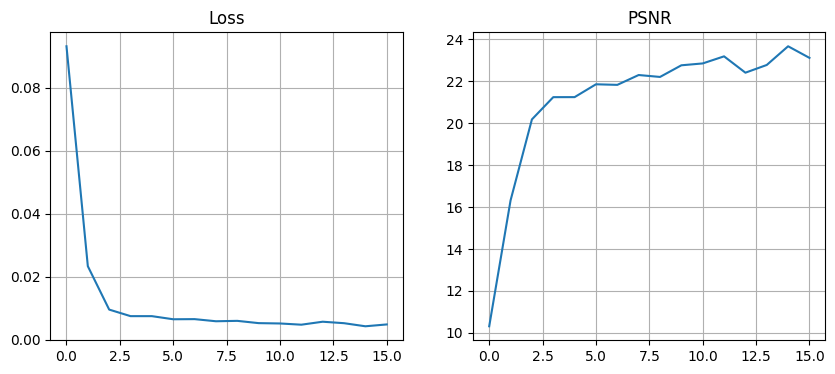

In [9]:
import torch.optim as optim
import time

class NeRFModel(nn.Module):
    def __init__(self, D=6, W=128, input_ch=39, output_ch=4, skip=3):
        super(NeRFModel, self).__init__()
        self.skip = skip
        self.input_ch = input_ch
        
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_ch, W))
        
        for i in range(D-1):
            if i == skip:
                self.layers.append(nn.Linear(W + input_ch, W))
            else:
                self.layers.append(nn.Linear(W, W))
        
        self.final = nn.Linear(W, output_ch)

    def forward(self, x):
        input_pts = x
        h = x
        for i, layer in enumerate(self.layers):
            h = F.relu(layer(h))
            if i == self.skip:
                h = torch.cat([input_pts, h], -1)
        
        return self.final(h)

N_iters = 3000
model = NeRFModel(D=6, W=128, input_ch=3 + 3*2*6, output_ch=4, skip=3).to(device)
optimizer = optim.Adam(model.parameters(), lr=5e-4)

print("Model re-initialized")
print("Restarting training...")

loss_history = []
psnr_history = []
start_time = time.time()

# Обучение
for i in range(N_iters + 1):
    # Выбор лучей
    idxs = torch.randint(0, all_rays_o.shape[0], (batch_size,), device=device)
    batch_rays_o = all_rays_o[idxs]
    batch_rays_d = all_rays_d[idxs]
    target_rgb = all_target_rgb[idxs]
    
    # Точки и кодирование
    pts, z_vals = sample_points(batch_rays_o, batch_rays_d, near, far, N_samples)
    encoded_pts = posenc(pts.reshape(-1, 3), L_embed=6)
    
    # Прогон
    raw = model(encoded_pts)
    raw = raw.reshape(batch_size, N_samples, 4)
    
    # Рендер
    rgb_map, _, _ = raw2outputs(raw, z_vals, batch_rays_d)
    
    # Лосс
    loss = torch.mean((rgb_map - target_rgb) ** 2)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if i % 200 == 0:
        psnr = -10. * torch.log10(loss)
        loss_history.append(loss.item())
        psnr_history.append(psnr.item())
        # Добавляем ETA (примерное время до конца)
        elapsed = time.time() - start_time
        eta = elapsed / (i + 1) * (N_iters - i)
        print(f"[Iter {i:04d}] Loss: {loss.item():.5f} | PSNR: {psnr.item():.2f} dB | ETA: {eta:.0f}s")

print(f"Done in {time.time() - start_time:.2f} s.")

# Графики
plt.figure(figsize=(10, 4))
plt.subplot(121); plt.plot(loss_history); plt.title("Loss"); plt.grid(True)
plt.subplot(122); plt.plot(psnr_history); plt.title("PSNR"); plt.grid(True)
plt.show()

Starting rendering test image...
Rendered in 0.59 s.


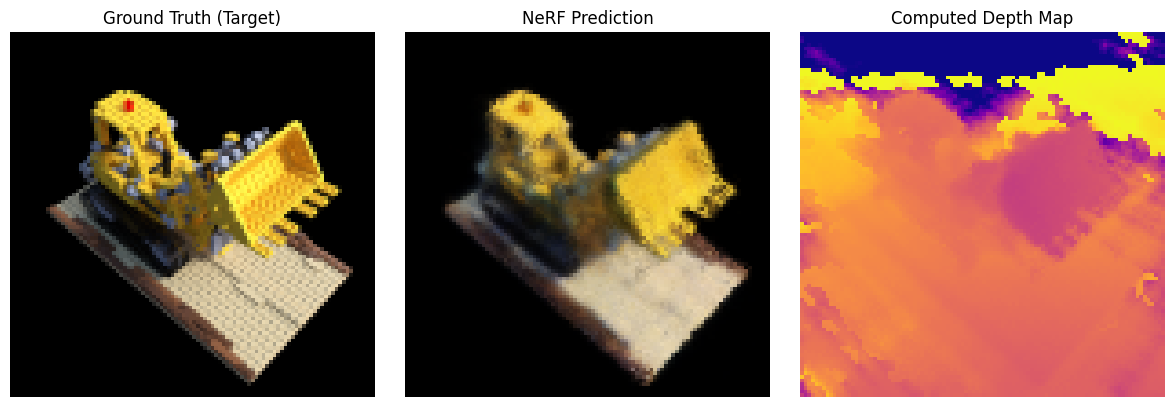

In [11]:
def render_full_image(c2w, H, W, focal, chunk=1024*4):

    # Рендерит целое изображение для заданной позы камеры
    # Лучи для всей картинки
    rays_o, rays_d = get_rays(H, W, focal, c2w)
    
    flat_rays_o = rays_o.reshape(-1, 3)
    flat_rays_d = rays_d.reshape(-1, 3)
    
    num_rays = flat_rays_o.shape[0]
    results_rgb = []
    results_depth = []
    
    with torch.no_grad(): # Отключаем градиенты для ускорения
        for i in range(0, num_rays, chunk):
            batch_rays_o = flat_rays_o[i : i+chunk]
            batch_rays_d = flat_rays_d[i : i+chunk]
            
            # Сэмплируем
            pts, z_vals = sample_points(batch_rays_o, batch_rays_d, near, far, N_samples)
            
            # Кодируем
            encoded_pts = posenc(pts.reshape(-1, 3), L_embed=6)
            
            # Прогон сети
            raw = model(encoded_pts)
            raw = raw.reshape(batch_rays_o.shape[0], N_samples, 4)
            
            # Рендер
            rgb, depth, _ = raw2outputs(raw, z_vals, batch_rays_d)
            
            results_rgb.append(rgb)
            results_depth.append(depth)
            
    # Собираем обратно в картинку
    rgb_map = torch.cat(results_rgb, 0).reshape(H, W, 3)
    depth_map = torch.cat(results_depth, 0).reshape(H, W)
    
    return rgb_map, depth_map

# Превращаем testpose из numpy array в torch tensor
c2w = torch.from_numpy(testpose).to(device).float()

print("Starting rendering test image...")
start_render = time.time()

# Рендерим тестовый кадр
test_rgb, test_depth = render_full_image(c2w, H, W, focal)

print(f"Rendered in {time.time() - start_render:.2f} s.")

# Визуализация
plt.figure(figsize=(12, 4))

plt.subplot(131)
plt.title("Ground Truth (Target)")
plt.imshow(testimg)
plt.axis('off')

plt.subplot(132)
plt.title("NeRF Prediction")
plt.imshow(test_rgb.cpu().numpy().clip(0, 1))
plt.axis('off')

plt.subplot(133)
plt.title("Computed Depth Map")
# Глубина показывает расстояние до объекта
plt.imshow(test_depth.cpu().numpy(), cmap='plasma')
plt.axis('off')

plt.tight_layout()
plt.show()

Points generated: 8752 (filtered from 10000)


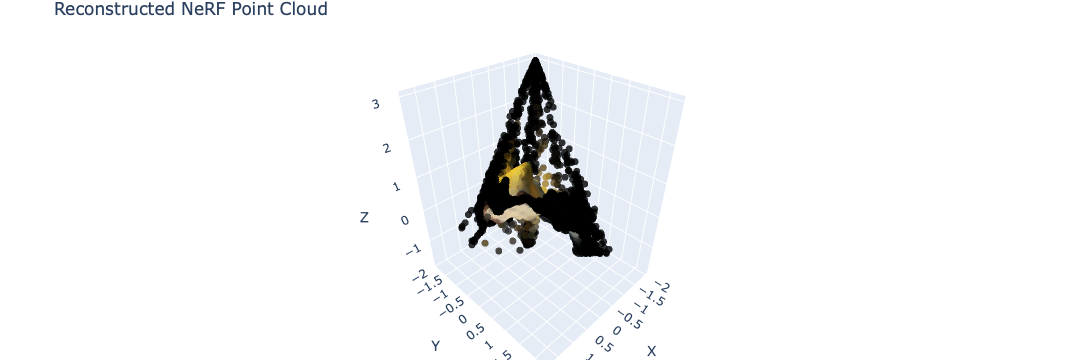

In [12]:
import plotly.graph_objects as go

# Генерация облака точек из глубины
rays_o, rays_d = get_rays(H, W, focal, c2w)

# Выпрямляем тензоры
rays_o_flat = rays_o.reshape(-1, 3)
rays_d_flat = rays_d.reshape(-1, 3)
depth_flat = test_depth.reshape(-1)
rgb_flat = test_rgb.reshape(-1, 3)

# Вычисляем координаты
points_3d = rays_o_flat + rays_d_flat * depth_flat.unsqueeze(-1)

# Фильтрация
mask = depth_flat < 5.0

# Переводим в Numpy для Plotly
points_np = points_3d[mask].cpu().numpy()
colors_np = rgb_flat[mask].cpu().numpy()

print(f"Points generated: {len(points_np)} (filtered from {H*W})")

# Визуализация в Plotly
fig = go.Figure(data=[go.Scatter3d(
    x=points_np[:, 0],
    y=points_np[:, 1],
    z=points_np[:, 2],
    mode='markers',
    marker=dict(
        size=4,
        color=colors_np,  
        opacity=0.8
    )
)])

# Настройка сцены
fig.update_layout(
    title="Reconstructed NeRF Point Cloud",
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
        aspectmode='data' 
    ),
    margin=dict(l=0, r=0, b=0, t=30)
)

fig.show()

In [14]:
import sys
!{sys.executable} -m pip install imageio

  Using cached imageio-2.37.2-py3-none-any.whl.metadata (9.7 kB)
Using cached imageio-2.37.2-py3-none-any.whl (317 kB)


Generating video poses...
Rendering 30 frames...
Rendered frame 5/30
Rendered frame 10/30
Rendered frame 15/30
Rendered frame 20/30
Rendered frame 25/30
Rendered frame 30/30
Video saved to lego_bulldozer_360.gif


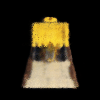

In [15]:
import imageio
import numpy as np
import torch

# Функции для генерации траектории камеры
def trans_t(t):
    return torch.tensor([
        [1,0,0,0],
        [0,1,0,0],
        [0,0,1,t],
        [0,0,0,1],
    ], dtype=torch.float32)

def rot_phi(phi):
    # Вращение вокруг оси X
    return torch.tensor([
        [1,0,0,0],
        [0, np.cos(phi), -np.sin(phi), 0],
        [0, np.sin(phi), np.cos(phi), 0],
        [0,0,0,1],
    ], dtype=torch.float32)

def rot_theta(th):
    # Вращение вокруг оси Y
    return torch.tensor([
        [np.cos(th), 0, -np.sin(th), 0],
        [0,1,0,0],
        [np.sin(th), 0, np.cos(th), 0],
        [0,0,0,1],
    ], dtype=torch.float32)

def pose_spherical(theta, phi, radius):

    # Генерирует матрицу позы камеры в сферических координатах
    c2w = trans_t(radius)
    c2w = rot_phi(phi/180.*np.pi) @ c2w
    c2w = rot_theta(theta/180.*np.pi) @ c2w
    c2w = torch.tensor([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]], dtype=torch.float32) @ c2w
    return c2w

print("Generating video poses...")
# Генерируем 30 кадров вращения (360 градусов)
render_poses = [pose_spherical(angle, -30.0, 4.0) for angle in np.linspace(-180, 180, 31)[:-1]]

frames = []
print(f"Rendering {len(render_poses)} frames...")

for i, c2w in enumerate(render_poses):
    c2w = c2w.to(device)
    
    # Рендерим кадр
    rgb, _ = render_full_image(c2w, H, W, focal)
    
    # Конвертируем в формат для картинки 
    frame = (rgb.cpu().numpy().clip(0, 1) * 255).astype(np.uint8)
    frames.append(frame)
    
    if (i+1) % 5 == 0:
        print(f"Rendered frame {i+1}/{len(render_poses)}")

# Сохраняем GIF
video_filename = 'lego_bulldozer_360.gif'
imageio.mimsave(video_filename, frames, fps=10)

print(f"Video saved to {video_filename}")

# Отображение в Jupyter
from IPython.display import Image
display(Image(filename=video_filename))

In [17]:
# Baby Yoda 
import os
import subprocess
import shutil

# Пути
project_path = "colmap_workspace"
images_path = "images"  
db_path = os.path.join(project_path, "database.db")
sparse_path = os.path.join(project_path, "sparse")

if os.path.exists(project_path):
    print("Cleaning up old workspace...")
    shutil.rmtree(project_path)
os.makedirs(project_path)
os.makedirs(sparse_path)

try:
    print("Feature Extraction...")
    cmd_feature = [
        "colmap", "feature_extractor",
        "--database_path", db_path,
        "--image_path", images_path,
        "--ImageReader.camera_model", "PINHOLE"
    ]
    subprocess.run(cmd_feature, check=True)

    print("Matching...")
    cmd_matcher = [
        "colmap", "exhaustive_matcher",
        "--database_path", db_path
    ]
    subprocess.run(cmd_matcher, check=True)

    print("Mapper...")
    cmd_mapper = [
        "colmap", "mapper",
        "--database_path", db_path,
        "--image_path", images_path,
        "--output_path", sparse_path
    ]
    subprocess.run(cmd_mapper, check=True)

    print("4. Converter (Bin to Txt)...")
    model_path = os.path.join(sparse_path, "0")
    if not os.path.exists(model_path):
        raise FileNotFoundError(f"COLMAP failed to reconstruct model. Check photos. Path not found: {model_path}")

    txt_path = os.path.join(sparse_path, "txt")
    os.makedirs(txt_path)
    
    cmd_converter = [
        "colmap", "model_converter",
        "--input_path", model_path,
        "--output_path", txt_path,
        "--output_type", "TXT"
    ]
    subprocess.run(cmd_converter, check=True)

    print("-" * 20)
    print("SUCCESS: COLMAP finished.")
    print(f"Data ready in: {txt_path}")
    print("-" * 20)

except subprocess.CalledProcessError as e:
    print(f"ERROR: COLMAP command failed with error code {e.returncode}")
except Exception as e:
    print(f"ERROR: {e}")

Cleaning up old workspace...
Feature Extraction...


I20260107 03:40:25.010581 5358421 misc.cc:44] 
Feature extraction
I20260107 03:40:25.027999 5358434 sift.cc:720] Creating SIFT GPU feature extractor
I20260107 03:40:25.064152 5358435 feature_extraction.cc:260] Processed file [1/54]
I20260107 03:40:25.064163 5358435 feature_extraction.cc:263]   Name:            .DS_Store
E20260107 03:40:25.064168 5358435 feature_extraction.cc:267] .DS_Store BITMAP_ERROR: Failed to read the image file format.
I20260107 03:40:25.480820 5358435 feature_extraction.cc:260] Processed file [2/54]
I20260107 03:40:25.480849 5358435 feature_extraction.cc:263]   Name:            1.jpg
I20260107 03:40:25.480854 5358435 feature_extraction.cc:272]   Dimensions:      5712 x 4284
I20260107 03:40:25.480857 5358435 feature_extraction.cc:275]   Camera:          #1 - PINHOLE
I20260107 03:40:25.480862 5358435 feature_extraction.cc:278]   Focal Length:    3960,25px (Prior)
I20260107 03:40:25.480866 5358435 feature_extraction.cc:282]   Features:        11738 (SIFT)
I20260107 

Matching...


I20260107 03:40:30.819783 5358518 misc.cc:44] 
Feature matching & geometric verification
I20260107 03:40:30.835841 5358519 sift.cc:1446] Creating SIFT GPU feature matcher
I20260107 03:40:30.853559 5358518 pairing.cc:180] Generating exhaustive image pairs...
I20260107 03:40:30.853566 5358518 pairing.cc:213] Processing block [1/2, 1/2]
I20260107 03:41:39.719602 5358518 feature_matching.cc:117] in 68,867s
I20260107 03:41:39.719648 5358518 pairing.cc:213] Processing block [1/2, 2/2]
I20260107 03:41:39.996412 5358518 feature_matching.cc:117] in 0,277s
I20260107 03:41:39.996443 5358518 pairing.cc:213] Processing block [2/2, 1/2]
I20260107 03:41:50.393616 5358518 feature_matching.cc:117] in 10,397s
I20260107 03:41:50.393687 5358518 pairing.cc:213] Processing block [2/2, 2/2]
I20260107 03:41:50.738266 5358518 feature_matching.cc:117] in 0,345s
I20260107 03:41:50.738332 5358518 timer.cc:90] Elapsed time: 1,332 [minutes]
I20260107 03:41:50.848079 5359236 incremental_pipeline.cc:264] Loading data

Mapper...


I20260107 03:41:51.108956 5359236 incremental_pipeline.cc:335] Registering initial image pair #8 and #5
I20260107 03:41:51.115039 5359236 incremental_pipeline.cc:349] Global bundle adjustment
I20260107 03:41:51.377307 5359236 incremental_pipeline.cc:439] Registering image #7 (num_reg_frames=2)
I20260107 03:41:51.377323 5359236 incremental_pipeline.cc:442] => Image sees 1362 / 9877 points
I20260107 03:41:51.638726 5359236 incremental_pipeline.cc:43] Retriangulation and Global bundle adjustment
I20260107 03:41:51.812481 5359236 incremental_pipeline.cc:439] Registering image #6 (num_reg_frames=3)
I20260107 03:41:51.812498 5359236 incremental_pipeline.cc:442] => Image sees 6043 / 9756 points
I20260107 03:41:52.647734 5359236 incremental_pipeline.cc:43] Retriangulation and Global bundle adjustment
I20260107 03:41:52.948776 5359236 incremental_pipeline.cc:439] Registering image #9 (num_reg_frames=4)
I20260107 03:41:52.948794 5359236 incremental_pipeline.cc:442] => Image sees 4972 / 9701 poin

4. Converter (Bin to Txt)...
--------------------
SUCCESS: COLMAP finished.
Data ready in: colmap_workspace/sparse/txt
--------------------


Loading Dataset...
Original Focal: 4194.80, New Focal: 73.44
Loaded 53 images
Scene centered and scaled by 1.08
Training. Images: torch.Size([53, 100, 100, 3]), Poses: torch.Size([53, 4, 4])


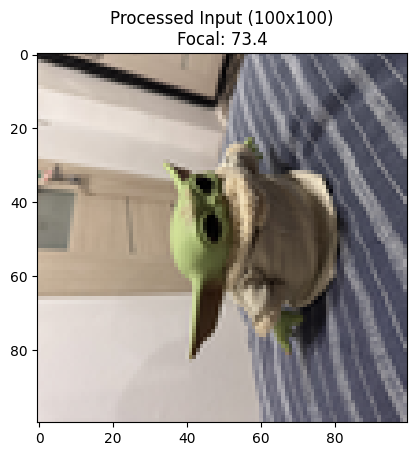

In [20]:
from PIL import Image
import numpy as np
import os
import torch
import matplotlib.pyplot as plt

# Вспомогательная функция для кватернионов
def qvec2rotmat(qvec):
    return np.array([
        [1 - 2 * qvec[2]**2 - 2 * qvec[3]**2,
         2 * qvec[1] * qvec[2] - 2 * qvec[0] * qvec[3],
         2 * qvec[3] * qvec[1] + 2 * qvec[0] * qvec[2]],
        [2 * qvec[1] * qvec[2] + 2 * qvec[0] * qvec[3],
         1 - 2 * qvec[1]**2 - 2 * qvec[3]**2,
         2 * qvec[2] * qvec[3] - 2 * qvec[0] * qvec[1]],
        [2 * qvec[3] * qvec[1] - 2 * qvec[0] * qvec[2],
         2 * qvec[2] * qvec[3] + 2 * qvec[0] * qvec[1],
         1 - 2 * qvec[1]**2 - 2 * qvec[2]**2]])

def load_colmap_data(basedir, target_H=100, target_W=100):
    camerasfile = os.path.join(basedir, 'sparse/txt/cameras.txt')
    imagesfile = os.path.join(basedir, 'sparse/txt/images.txt')

    # Читаем параметры камеры
    if not os.path.exists(camerasfile):
        raise FileNotFoundError(f"File not found: {camerasfile}. Did COLMAP finish successfully?")

    with open(camerasfile, "r") as f:
        for line in f:
            if line.startswith("#"): continue
            els = line.split()
            # ID, MODEL, WIDTH, HEIGHT, PARAMS[]
            w_orig = float(els[2])
            fl_orig = float(els[4]) 
            break
            
    # Масштабный коэффициент
    scale_factor = target_W / w_orig
    focal_new = fl_orig * scale_factor
    
    print(f"Original Focal: {fl_orig:.2f}, New Focal: {focal_new:.2f}")

    # Читаем позы изображений
    poses = []
    images = []
    
    with open(imagesfile, "r") as f:
        i = 0
        while True:
            line = f.readline()
            if not line: break
            if line.startswith("#"): continue
            
            elems = line.split()
            image_id = int(elems[0])
            qvec = np.array(tuple(map(float, elems[1:5])))
            tvec = np.array(tuple(map(float, elems[5:8])))
            name = elems[9]
            
            f.readline() 
            
            R = qvec2rotmat(qvec)
            t = tvec.reshape([3,1])
            R_inv = R.T
            t_inv = -R_inv @ t
            
            pose = np.eye(4)
            pose[:3, :3] = R_inv
            pose[:3, 3] = t_inv.squeeze()
            
            # Конвертация координат: COLMAP - NeRF
            blend_coords = np.array([
                [1, 0, 0, 0],
                [0, -1, 0, 0],
                [0, 0, -1, 0],
                [0, 0, 0, 1]
            ])
            pose = pose @ blend_coords
            
            img_path = os.path.join('images', name)
            
            if not os.path.exists(img_path):
                 img_path = os.path.join('images', os.path.basename(name))

            img = Image.open(img_path)
            img = img.resize((target_W, target_H), Image.Resampling.LANCZOS)
            img = np.array(img) / 255.0
            
            poses.append(pose)
            images.append(img)
            
    poses = np.array(poses).astype(np.float32)
    images = np.array(images).astype(np.float32)
    
    # Центровка и нормализация
    avg_pose = np.mean(poses[:, :3, 3], axis=0)
    poses[:, :3, 3] -= avg_pose
    
    dists = np.linalg.norm(poses[:, :3, 3], axis=1)
    scale = 4.0 / np.mean(dists)
    poses[:, :3, 3] *= scale
    
    print(f"Loaded {len(images)} images")
    print(f"Scene centered and scaled by {scale:.2f}")
    
    return images, poses, focal_new

print("Loading Dataset...")
custom_images_np, custom_poses_np, custom_focal_val = load_colmap_data("colmap_workspace", target_H=100, target_W=100)

# Переводим в Torch
images = torch.from_numpy(custom_images_np[..., :3]).to(device)
poses = torch.from_numpy(custom_poses_np).to(device)
focal = torch.tensor(custom_focal_val).to(device)
H, W = 100, 100

print(f"Training. Images: {images.shape}, Poses: {poses.shape}")

# Проверка
plt.imshow(images[0].cpu())
plt.title(f"Processed Input (100x100)\nFocal: {custom_focal_val:.1f}")
plt.show()

Pre-computing rays for Baby Yoda dataset...
Total rays: 530000
Starting training loop (Yoda)...
[Iter 0000] Loss: 0.07138 | PSNR: 11.46 dB | ETA: 356s
[Iter 0200] Loss: 0.02551 | PSNR: 15.93 dB | ETA: 274s
[Iter 0400] Loss: 0.02262 | PSNR: 16.46 dB | ETA: 254s
[Iter 0600] Loss: 0.02657 | PSNR: 15.76 dB | ETA: 236s
[Iter 0800] Loss: 0.02085 | PSNR: 16.81 dB | ETA: 218s
[Iter 1000] Loss: 0.02159 | PSNR: 16.66 dB | ETA: 198s
[Iter 1200] Loss: 0.02175 | PSNR: 16.62 dB | ETA: 178s
[Iter 1400] Loss: 0.01907 | PSNR: 17.20 dB | ETA: 158s
[Iter 1600] Loss: 0.01893 | PSNR: 17.23 dB | ETA: 138s
[Iter 1800] Loss: 0.01836 | PSNR: 17.36 dB | ETA: 119s
[Iter 2000] Loss: 0.01796 | PSNR: 17.46 dB | ETA: 99s
[Iter 2200] Loss: 0.01878 | PSNR: 17.26 dB | ETA: 79s
[Iter 2400] Loss: 0.01682 | PSNR: 17.74 dB | ETA: 59s
[Iter 2600] Loss: 0.01741 | PSNR: 17.59 dB | ETA: 40s
[Iter 2800] Loss: 0.01651 | PSNR: 17.82 dB | ETA: 20s
[Iter 3000] Loss: 0.01818 | PSNR: 17.40 dB | ETA: 0s
Yoda training finished in 296.9

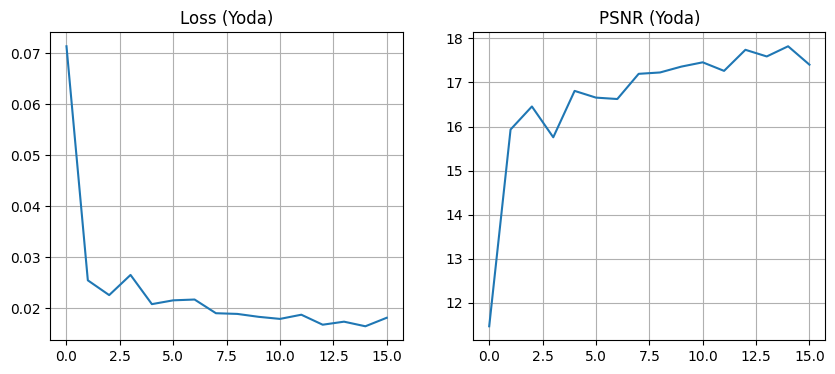

In [22]:
import torch.optim as optim
import time

# Гиперпараметры
N_iters_yoda = 3000  
batch_size = 1024
N_samples = 64
lr = 5e-4
near = 2.0
far = 6.0

# Инициализация модели для Йоды
model_yoda = NeRFModel(D=6, W=128, input_ch=3 + 3*2*6, output_ch=4, skip=3).to(device)
optimizer_yoda = optim.Adam(model_yoda.parameters(), lr=lr)

print("Pre-computing rays for Baby Yoda dataset...")
yoda_rays_o = []
yoda_rays_d = []
yoda_target_rgb = []

num_images = images.shape[0]

for i in range(num_images):
    ro, rd = get_rays(H, W, focal, poses[i])
    yoda_rays_o.append(ro)
    yoda_rays_d.append(rd)
    yoda_target_rgb.append(images[i])

# Объединяем в один большой тензор
yoda_rays_o = torch.stack(yoda_rays_o, 0).reshape(-1, 3)
yoda_rays_d = torch.stack(yoda_rays_d, 0).reshape(-1, 3)
yoda_target_rgb = torch.stack(yoda_target_rgb, 0).reshape(-1, 3)

print(f"Total rays: {yoda_rays_o.shape[0]}")
print("Starting training loop (Yoda)...")

# Обучение
loss_history_yoda = []
psnr_history_yoda = []
start_time = time.time()

for i in range(N_iters_yoda + 1):
    # Выбор случайных лучей
    idxs = torch.randint(0, yoda_rays_o.shape[0], (batch_size,), device=device)
    
    batch_rays_o = yoda_rays_o[idxs]
    batch_rays_d = yoda_rays_d[idxs]
    target_rgb = yoda_target_rgb[idxs]
    
    # Сэмплирование точек
    pts, z_vals = sample_points(batch_rays_o, batch_rays_d, near, far, N_samples)
    
    # Кодирование
    encoded_pts = posenc(pts.reshape(-1, 3), L_embed=6)
    
    # Прогон через нейросеть
    raw = model_yoda(encoded_pts)
    raw = raw.reshape(batch_size, N_samples, 4)
    
    # Рендеринг
    rgb_map, _, _ = raw2outputs(raw, z_vals, batch_rays_d)
    
    # Ошибка и шаг
    loss = torch.mean((rgb_map - target_rgb) ** 2)
    
    optimizer_yoda.zero_grad()
    loss.backward()
    optimizer_yoda.step()
    
    # Логирование
    if i % 200 == 0:
        psnr = -10. * torch.log10(loss)
        loss_history_yoda.append(loss.item())
        psnr_history_yoda.append(psnr.item())
        
        elapsed = time.time() - start_time
        eta = elapsed / (i + 1) * (N_iters_yoda - i)
        print(f"[Iter {i:04d}] Loss: {loss.item():.5f} | PSNR: {psnr.item():.2f} dB | ETA: {eta:.0f}s")

print(f"Yoda training finished in {time.time() - start_time:.2f} s.")

# Графики
plt.figure(figsize=(10, 4))
plt.subplot(121); plt.plot(loss_history_yoda); plt.title("Loss (Yoda)"); plt.grid(True)
plt.subplot(122); plt.plot(psnr_history_yoda); plt.title("PSNR (Yoda)"); plt.grid(True)
plt.show()

Generating 360 video for Baby Yoda...
Rendered 5/30
Rendered 10/30
Rendered 15/30
Rendered 20/30
Rendered 25/30
Rendered 30/30
Saved baby_yoda_360.gif


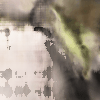

In [24]:
print("Generating 360 video for Baby Yoda...")

render_poses_yoda = [pose_spherical(angle, -20.0, 4.0) for angle in np.linspace(-180, 180, 31)[:-1]]

frames_yoda = []

def render_full_image_custom(model, c2w, H, W, focal, chunk=1024*4):
    rays_o, rays_d = get_rays(H, W, focal, c2w)
    flat_rays_o = rays_o.reshape(-1, 3)
    flat_rays_d = rays_d.reshape(-1, 3)
    
    num_rays = flat_rays_o.shape[0]
    results_rgb = []
    
    with torch.no_grad():
        for i in range(0, num_rays, chunk):
            batch_rays_o = flat_rays_o[i : i+chunk]
            batch_rays_d = flat_rays_d[i : i+chunk]
            
            pts, z_vals = sample_points(batch_rays_o, batch_rays_d, near, far, N_samples)
            encoded_pts = posenc(pts.reshape(-1, 3), L_embed=6)
            
            raw = model(encoded_pts)
            raw = raw.reshape(batch_rays_o.shape[0], N_samples, 4)
            rgb, _, _ = raw2outputs(raw, z_vals, batch_rays_d)
            results_rgb.append(rgb)
            
    return torch.cat(results_rgb, 0).reshape(H, W, 3)

for i, c2w in enumerate(render_poses_yoda):
    c2w = c2w.to(device)
    rgb = render_full_image_custom(model_yoda, c2w, H, W, focal)
    frame = (rgb.cpu().numpy().clip(0, 1) * 255).astype(np.uint8)
    frames_yoda.append(frame)
    if (i+1) % 5 == 0:
        print(f"Rendered {i+1}/30")

video_filename_yoda = 'baby_yoda_360.gif'
imageio.mimsave(video_filename_yoda, frames_yoda, fps=10)
print(f"Saved {video_filename_yoda}")

from IPython.display import Image as IPImage
display(IPImage(filename='baby_yoda_360.gif'))

Rendering comparison for Yoda (frame 0)...


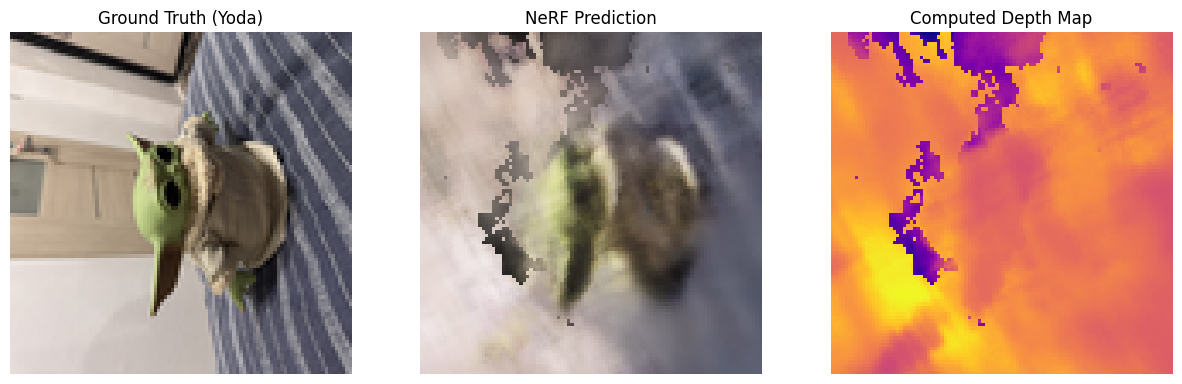

In [26]:
# Выбираем первый кадр для теста
test_idx = 0
target_img = images[test_idx].cpu().numpy()
target_pose = poses[test_idx]

print(f"Rendering comparison for Yoda (frame {test_idx})...")

# Функция рендеринга
def render_yoda_test(model, c2w, H, W, focal):
    rays_o, rays_d = get_rays(H, W, focal, c2w)
    flat_o, flat_d = rays_o.reshape(-1, 3), rays_d.reshape(-1, 3)
    
    chunk = 4096
    rgbs, depths = [], []
    
    with torch.no_grad():
        for i in range(0, flat_o.shape[0], chunk):
            batch_o, batch_d = flat_o[i:i+chunk], flat_d[i:i+chunk]
            pts, z_vals = sample_points(batch_o, batch_d, near, far, N_samples)
            encoded = posenc(pts.reshape(-1, 3), L_embed=6)
            raw = model(encoded).reshape(batch_o.shape[0], N_samples, 4)
            rgb, depth, _ = raw2outputs(raw, z_vals, batch_d)
            rgbs.append(rgb)
            depths.append(depth)
            
    return torch.cat(rgbs, 0).reshape(H, W, 3), torch.cat(depths, 0).reshape(H, W)

yoda_rgb, yoda_depth = render_yoda_test(model_yoda, target_pose, H, W, focal)

# Визуализация
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.title("Ground Truth (Yoda)")
plt.imshow(target_img)
plt.axis('off')

plt.subplot(132)
plt.title("NeRF Prediction")
plt.imshow(yoda_rgb.cpu().numpy().clip(0, 1))
plt.axis('off')

plt.subplot(133)
plt.title("Computed Depth Map")
plt.imshow(yoda_depth.cpu().numpy(), cmap='plasma')
plt.axis('off')

plt.show()

In [28]:
import torch.optim as optim
import time

# Попытка сделать лучше
N_iters_heavy = 10000 
batch_size = 1024
N_samples = 64
lr = 5e-4

# Архитектура (D=8, W=256) 
model_yoda_heavy = NeRFModel(D=8, W=256, input_ch=3 + 3*2*6, output_ch=4, skip=4).to(device)
optimizer_heavy = optim.Adam(model_yoda_heavy.parameters(), lr=lr)

print("Starting Training for Baby Yoda...")
start_time = time.time()

# Обучение
for i in range(N_iters_heavy + 1):
    # Выбор случайных лучей из заранее вычисленных
    idxs = torch.randint(0, yoda_rays_o.shape[0], (batch_size,), device=device)
    
    batch_rays_o = yoda_rays_o[idxs]
    batch_rays_d = yoda_rays_d[idxs]
    target_rgb = yoda_target_rgb[idxs]
    
    # Сэмплирование и кодирование
    pts, z_vals = sample_points(batch_rays_o, batch_rays_d, near, far, N_samples)
    encoded_pts = posenc(pts.reshape(-1, 3), L_embed=6)
    
    # Forward pass
    raw = model_yoda_heavy(encoded_pts).reshape(batch_size, N_samples, 4)
    rgb_map, _, _ = raw2outputs(raw, z_vals, batch_rays_d)
    
    # Loss
    loss = torch.mean((rgb_map - target_rgb) ** 2)
    
    optimizer_heavy.zero_grad()
    loss.backward()
    optimizer_heavy.step()
    
    # Логирование каждые 500 шагов
    if i % 500 == 0:
        psnr = -10. * torch.log10(loss)
        elapsed = time.time() - start_time
        eta = elapsed / (i + 1) * (N_iters_heavy - i)
        print(f"[Iter {i:05d}] Loss: {loss.item():.5f} | PSNR: {psnr.item():.2f} dB | ETA: {eta:.0f}s")

model_yoda = model_yoda_heavy

print(f"Training finished in {time.time() - start_time:.2f} s.")

Starting Training for Baby Yoda...
[Iter 00000] Loss: 0.30129 | PSNR: 5.21 dB | ETA: 3618s
[Iter 00500] Loss: 0.02596 | PSNR: 15.86 dB | ETA: 2725s
[Iter 01000] Loss: 0.01911 | PSNR: 17.19 dB | ETA: 2584s
[Iter 01500] Loss: 0.01625 | PSNR: 17.89 dB | ETA: 2447s
[Iter 02000] Loss: 0.01744 | PSNR: 17.58 dB | ETA: 2301s
[Iter 02500] Loss: 0.01617 | PSNR: 17.91 dB | ETA: 4446s
[Iter 03000] Loss: 0.01464 | PSNR: 18.35 dB | ETA: 3788s
[Iter 03500] Loss: 0.01553 | PSNR: 18.09 dB | ETA: 3279s
[Iter 04000] Loss: 0.01501 | PSNR: 18.24 dB | ETA: 2863s
[Iter 04500] Loss: 0.01517 | PSNR: 18.19 dB | ETA: 2507s
[Iter 05000] Loss: 0.01221 | PSNR: 19.13 dB | ETA: 4046s
[Iter 05500] Loss: 0.01399 | PSNR: 18.54 dB | ETA: 5663s
[Iter 06000] Loss: 0.01278 | PSNR: 18.93 dB | ETA: 6028s
[Iter 06500] Loss: 0.01272 | PSNR: 18.95 dB | ETA: 6011s
[Iter 07000] Loss: 0.01221 | PSNR: 19.13 dB | ETA: 5902s
[Iter 07500] Loss: 0.01230 | PSNR: 19.10 dB | ETA: 5455s
[Iter 08000] Loss: 0.01296 | PSNR: 18.87 dB | ETA: 459

Rendering comparison for Yoda (frame 0)...


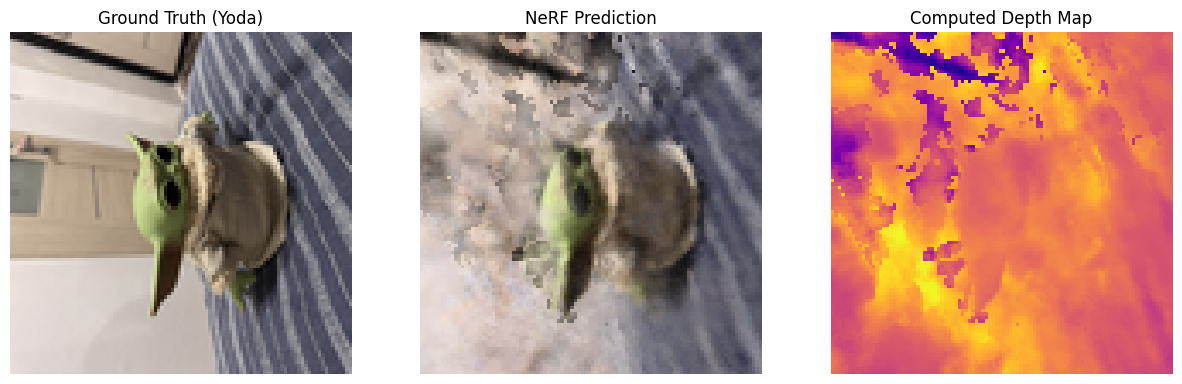

In [29]:
# Выбираем первый кадр для теста
test_idx = 0
target_img = images[test_idx].cpu().numpy()
target_pose = poses[test_idx]

print(f"Rendering comparison for Yoda (frame {test_idx})...")

# Функция рендеринга
def render_yoda_test(model, c2w, H, W, focal):
    rays_o, rays_d = get_rays(H, W, focal, c2w)
    flat_o, flat_d = rays_o.reshape(-1, 3), rays_d.reshape(-1, 3)
    
    chunk = 4096
    rgbs, depths = [], []
    
    with torch.no_grad():
        for i in range(0, flat_o.shape[0], chunk):
            batch_o, batch_d = flat_o[i:i+chunk], flat_d[i:i+chunk]
            pts, z_vals = sample_points(batch_o, batch_d, near, far, N_samples)
            encoded = posenc(pts.reshape(-1, 3), L_embed=6)
            raw = model(encoded).reshape(batch_o.shape[0], N_samples, 4)
            rgb, depth, _ = raw2outputs(raw, z_vals, batch_d)
            rgbs.append(rgb)
            depths.append(depth)
            
    return torch.cat(rgbs, 0).reshape(H, W, 3), torch.cat(depths, 0).reshape(H, W)

yoda_rgb, yoda_depth = render_yoda_test(model_yoda, target_pose, H, W, focal)

# Визуализация
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.title("Ground Truth (Yoda)")
plt.imshow(target_img)
plt.axis('off')

plt.subplot(132)
plt.title("NeRF Prediction")
plt.imshow(yoda_rgb.cpu().numpy().clip(0, 1))
plt.axis('off')

plt.subplot(133)
plt.title("Computed Depth Map")
plt.imshow(yoda_depth.cpu().numpy(), cmap='plasma')
plt.axis('off')

plt.show()

Yoda points: 9885


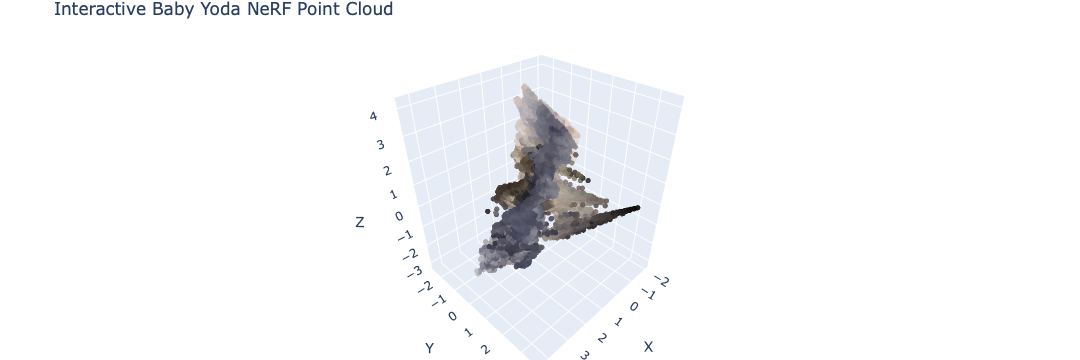

In [31]:
import plotly.graph_objects as go

# Генерация координат из глубины
rays_o, rays_d = get_rays(H, W, focal, target_pose)
rays_o_f = rays_o.reshape(-1, 3)
rays_d_f = rays_d.reshape(-1, 3)
depth_f = yoda_depth.reshape(-1)
rgb_f = yoda_rgb.reshape(-1, 3)

# P = O + D * depth
points_3d = rays_o_f + rays_d_f * depth_f.unsqueeze(-1)

# Фильтрация фона
mask = depth_f < 5.5 

pts_np = points_3d[mask].cpu().numpy()
clr_np = rgb_f[mask].cpu().numpy().clip(0, 1)

print(f"Yoda points: {len(pts_np)}")

# Plotly визуализация
fig = go.Figure(data=[go.Scatter3d(
    x=pts_np[:, 0], y=pts_np[:, 1], z=pts_np[:, 2],
    mode='markers',
    marker=dict(size=3, color=clr_np, opacity=0.9)
)])

fig.update_layout(
    title="Interactive Baby Yoda NeRF Point Cloud",
    scene=dict(
        xaxis_title='X', yaxis_title='Y', zaxis_title='Z',
        aspectmode='data'
    ),
    margin=dict(l=0, r=0, b=0, t=30)
)
fig.show()